# STAT 4710J Final Data Challenge

A taxi company is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an rider share app account. We consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days. **The data was collected at the end of June 30, 2014.**
We would like you to use this dataset to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help the company.
The data is in the attached file data_challenge.json. See below for a detailed
description of the dataset. 

**Data description**

city: city this user signed up in

phone: primary device for this user

signup_date: date of account registration; in the form ‘YYYYMMDD’

last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’

avg_dist: the average distance in miles per trip taken in the first 30 days after signup

avg_rating_by_driver: the rider’s average rating over all of their trips

avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips

surge_pct: the percent of trips taken with surge multiplier > 1

avg_surge: The average surge multiplier over all of this user’s trips

trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up

ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;

FALSE otherwise

weekday_pct: the percent of the user’s trips occurring during a weekday



Please include any code you wrote for the analysis.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis.
2. Build a predictive model to help the company determine whether or not a user will be active
on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.


**If you use Chatgpt in any of the sections, please state clearly how you reference Chatgpt, with a proper declaration, we might take you points off if we find duplicate codes produced from Chatgpt**

Grade break down: 60% on data analysis in the notebook (completeness, accuracy and interpretation) + 40% on test accuracy



In [1]:
#set up environment
import pandas as pd
import numpy as np
import json
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

#load data and visualize
with open('train.json') as f:
    data = json.load(f)
    
df = pd.DataFrame(data)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,Winterfell,1,2014-01-27,3.5,1.67,2014-06-22,iPhone,33.3,True,16.7,2.10,4.8
1,King's Landing,1,2014-01-11,5.0,1.00,2014-06-08,iPhone,0.0,False,0.0,7.30,5.0
2,King's Landing,0,2014-01-23,3.0,1.00,2014-06-27,iPhone,0.0,True,100.0,4.00,5.0
3,King's Landing,0,2014-01-17,4.0,1.00,2014-05-31,Android,0.0,False,33.3,6.73,5.0
4,King's Landing,1,2014-01-28,5.0,1.16,2014-06-20,iPhone,26.9,True,50.0,2.48,4.8


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47500 entries, 0 to 47499
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    47500 non-null  object 
 1   trips_in_first_30_days  47500 non-null  int64  
 2   signup_date             47500 non-null  object 
 3   avg_rating_of_driver    39746 non-null  float64
 4   avg_surge               47500 non-null  float64
 5   last_trip_date          47500 non-null  object 
 6   phone                   47128 non-null  object 
 7   surge_pct               47500 non-null  float64
 8   ultimate_black_user     47500 non-null  bool   
 9   weekday_pct             47500 non-null  float64
 10  avg_dist                47500 non-null  float64
 11  avg_rating_by_driver    47311 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.4+ MB


In [3]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,47500.000000,39746.000000,47500.000000,47500.000000,47500.000000,47500.000000,47311.000000
mean,2.275158,4.602186,1.074716,8.852829,60.966623,5.799024,4.778400
std,3.789220,0.617603,0.222291,19.993570,37.064133,5.677958,0.447863
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.890000,5.000000
75%,3.000000,5.000000,1.050000,8.500000,100.000000,6.950000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,129.890000,5.000000


### 1. EDA
a. First of all, all the users will need to be labled by active or inactive, and categorical variables must be encoded. The null values must be accounted for. While the reason for the missing ratings cannot be inferred, it seems reasonable that the user/driver simply declined to input a rating. In this case, we will fill with the **mean value** so as to not affect the current distribution, which is primarily high ratings.

In [4]:
#fill missing values in avg_rating_by_driver and avg_rating_of_driver

df.avg_rating_by_driver.fillna(df.avg_rating_by_driver.mean(), inplace=True)
df.avg_rating_of_driver.fillna(df.avg_rating_of_driver.mean(), inplace=True)
# print(df.isna().sum())


b. The target variable will be whether the user was active. Convert the signup date and last trip date to datetime objects. If the last trip is in June, then encode each user active as True, else False.

In [5]:
#set as datatime objects
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
# df.info()

In [6]:
#encode target variable 'active' as true or false for last trip in june
# you can add more lines before assigning the 'active' column
df['active'] = df['last_trip_date'].apply(lambda date: True if date.month == 6 else False)
active_users = df['active'].sum()
print(active_users)

17320


#### What is the ratio of Active Users to Inactive Users?
Compute the percentage of active users among all users, and make a plot to visualize it.

Percentage of active users =  36.46315789473684


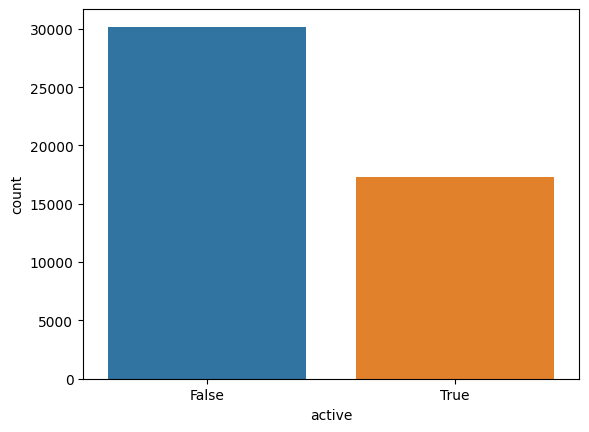

In [7]:
#Calculate ratio of active to all users
active_users = df[df['active']==True].shape[0]
total_users = df.shape[0]
print('Percentage of active users = ',(active_users/total_users)*100)
#Visualization
sns.countplot(x="active", data=df)
plt.show()


Unsurprisingly the classes are imbalanced, but not tremendously. This should not present too much of a problem while modeling.

c. In the cell below, show a visualization that you used to select features for your model.

Include:

1. At least one plot showing something meaningful about the data that helped you during feature selection, model selection, or both.

2. Two or three sentences describing what you plotted and its implications with respect to your features.



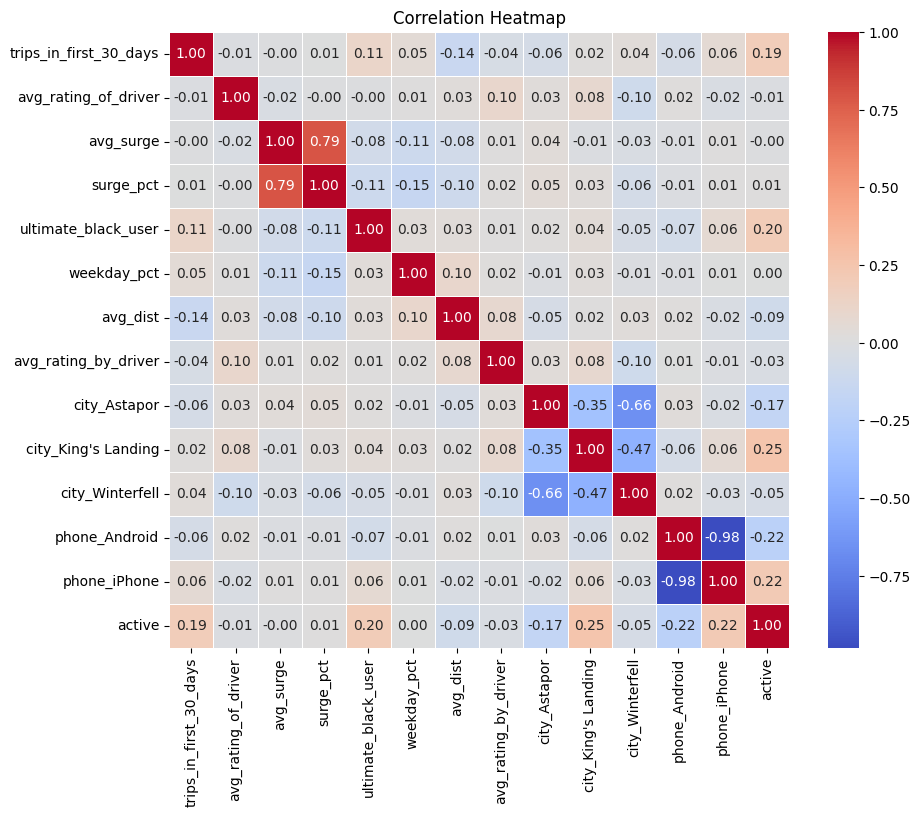

In [8]:
df['phone'] = df['phone'].astype('category')
df = pd.get_dummies(df, columns=['city', 'phone'])
X = df.drop(['active', 'signup_date', 'last_trip_date'], axis=1)
y = df['active']

correlation = pd.concat([X, y], axis=1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


# The code used in this solution was generated by myself with guidance and code help from GPT4. I asked GPT how to plot a heatmap.

I categorized the city and phone to be integers, and then plotted the heatmap. The significent row I refer to is the last row, that plot the correlation between active and other features.

For example, we can notice that `trips_in_first_30_days`, `ultimate_black_user`,`city_King's Landing` and `phone_iPhone` have positive correlation with `active`. While `avg_dist`, `city_Astapor`, `city_Winterfell` and `phone_Android` have negative correlation with `active`.

## 2. Modeling

Now, please perform feature engineering to build a model that can predict whether the users are active. (To get full credit, you need to make some visualization and try out several different models using cross validation)

In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Define features
features = ['trips_in_first_30_days', 'ultimate_black_user', 
        "city_King's Landing", 'phone_iPhone', 'phone_Android',
        'avg_dist', 'city_Astapor', 'city_Winterfell']
X = df[features]
y = df['active']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=123)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Train Accuracy: 0.7148771929824561
Test Accuracy: 0.7131578947368421


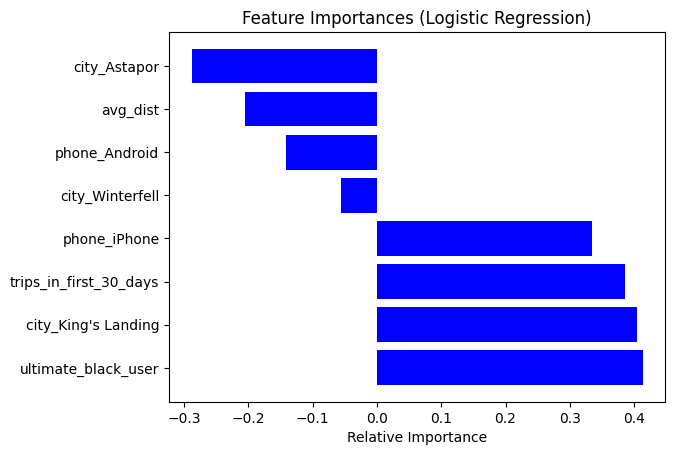

In [45]:
lr_model = LogisticRegression()
lr_model.fit(X_train_scaled, y_train)

print(f"Train Accuracy: {accuracy_score(y_train, lr_model.predict(X_train_scaled))}")
print(f"Test Accuracy: {accuracy_score(y_test, lr_model.predict(X_test_scaled))}")

# Since Logistic Regression doesn't directly provide feature importances, we can use the coefficients
importances = lr_model.coef_[0]
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title('Feature Importances (Logistic Regression)')
plt.barh(range(X.shape[1]), importances[indices], color='b', align='center')
plt.yticks(range(X.shape[1]), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Train Accuracy: 0.9291929824561403
Test Accuracy: 0.6547368421052632


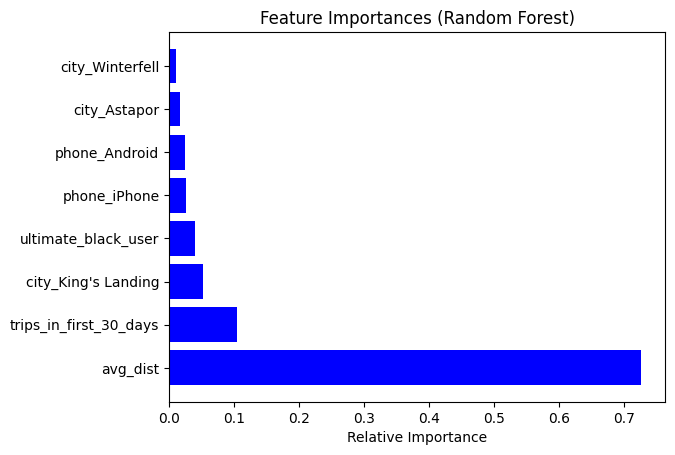

In [46]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train_scaled, y_train)

print(f"Train Accuracy: {accuracy_score(y_train, rf_model.predict(X_train_scaled))}")
print(f"Test Accuracy: {accuracy_score(y_test, rf_model.predict(X_test_scaled))}")
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title('Feature Importances (Random Forest)')
plt.barh(range(X.shape[1]), importances[indices], color='b', align='center')
plt.yticks(range(X.shape[1]), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


Train Accuracy: 0.7824210526315789
Test Accuracy: 0.6884736842105263


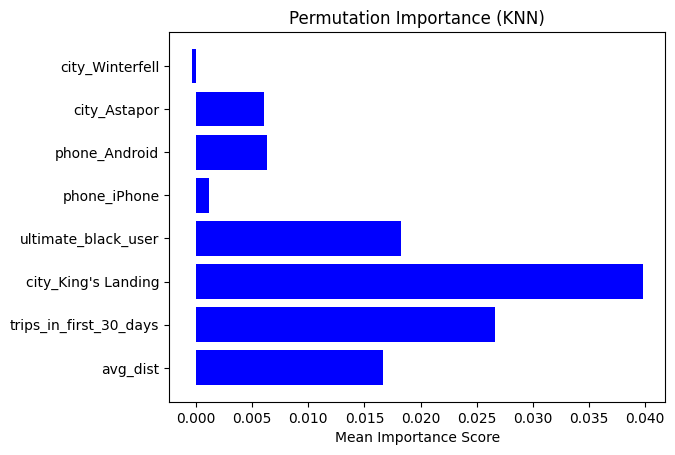

In [47]:
from sklearn.inspection import permutation_importance
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_scaled, y_train)

print(f"Train Accuracy: {accuracy_score(y_train, knn_model.predict(X_train_scaled))}")
print(f"Test Accuracy: {accuracy_score(y_test, knn_model.predict(X_test_scaled))}")
# Fit KNN model and get permutation importance
knn_results = permutation_importance(knn_model, X_test_scaled, y_test, scoring='accuracy')

# Plot the permutation importance
plt.figure()
plt.title('Permutation Importance (KNN)')
plt.barh(range(X.shape[1]), knn_results.importances_mean[indices], color='b', align='center')
plt.yticks(range(X.shape[1]), [features[i] for i in indices])
plt.xlabel('Mean Importance Score')
plt.show()


Train Accuracy: 0.7365964912280701
Test Accuracy: 0.7284736842105263


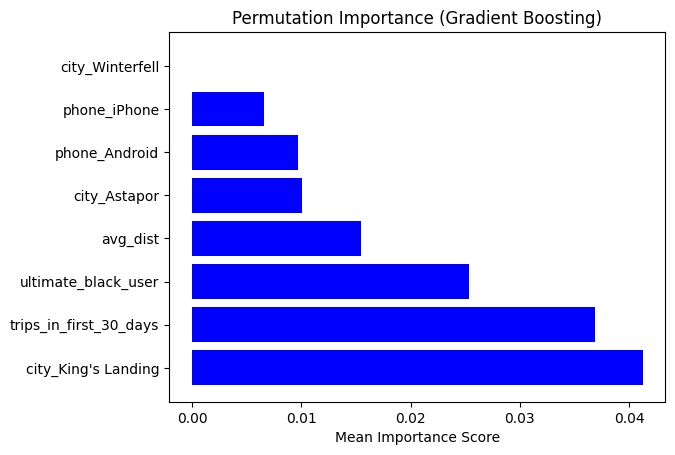

In [48]:
gbc_model = GradientBoostingClassifier()
gbc_model.fit(X_train_scaled, y_train)

print(f"Train Accuracy: {accuracy_score(y_train, gbc_model.predict(X_train_scaled))}")
print(f"Test Accuracy: {accuracy_score(y_test, gbc_model.predict(X_test_scaled))}")

gbc_results = permutation_importance(gbc_model, X_test_scaled, y_test, scoring='accuracy')

# Sort features according to importance
indices = np.argsort(gbc_results.importances_mean)[::-1]

# Plot the permutation importance
plt.figure()
plt.title('Permutation Importance (Gradient Boosting)')
plt.barh(range(X.shape[1]), gbc_results.importances_mean[indices], color='b', align='center')
plt.yticks(range(X.shape[1]), [features[i] for i in indices])
plt.xlabel('Mean Importance Score')
plt.show()


## 3. Model Evaluation

The bottom line here is: Was the model useful? You need to check both **numerical metrics and visual metrics**. **Please explain different performance metrics and your results.**

Classification report for LogisticRegression:

              precision    recall  f1-score   support

       False       0.74      0.86      0.79     12122
        True       0.65      0.46      0.54      6878

    accuracy                           0.71     19000
   macro avg       0.69      0.66      0.66     19000
weighted avg       0.70      0.71      0.70     19000

ROC AUC score for LogisticRegression:

0.7513845198128422 




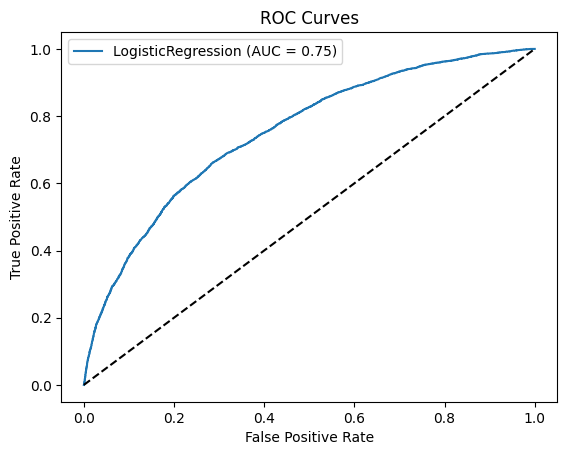

Classification report for RandomForestClassifier:

              precision    recall  f1-score   support

       False       0.73      0.73      0.73     12122
        True       0.52      0.51      0.52      6878

    accuracy                           0.65     19000
   macro avg       0.63      0.62      0.62     19000
weighted avg       0.65      0.65      0.65     19000

ROC AUC score for RandomForestClassifier:

0.6924822749272097 




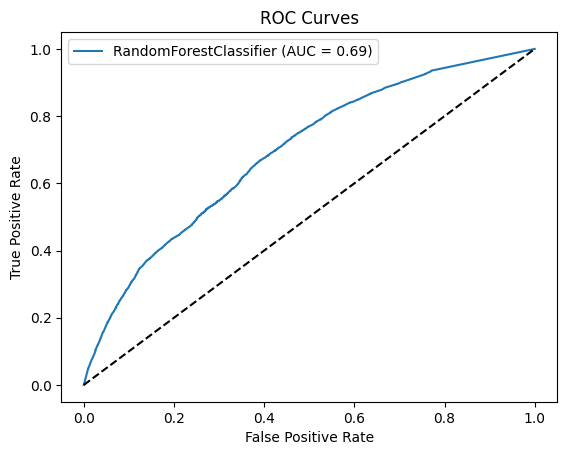

Classification report for KNeighborsClassifier:

              precision    recall  f1-score   support

       False       0.74      0.79      0.76     12122
        True       0.58      0.51      0.54      6878

    accuracy                           0.69     19000
   macro avg       0.66      0.65      0.65     19000
weighted avg       0.68      0.69      0.68     19000

ROC AUC score for KNeighborsClassifier:

0.7099760316975152 




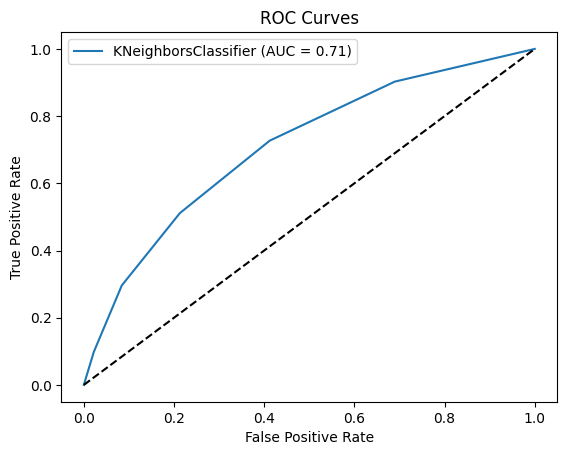

Classification report for GradientBoostingClassifier:

              precision    recall  f1-score   support

       False       0.75      0.85      0.80     12122
        True       0.66      0.51      0.57      6878

    accuracy                           0.73     19000
   macro avg       0.71      0.68      0.69     19000
weighted avg       0.72      0.73      0.72     19000

ROC AUC score for GradientBoostingClassifier:

0.7778156794408537 




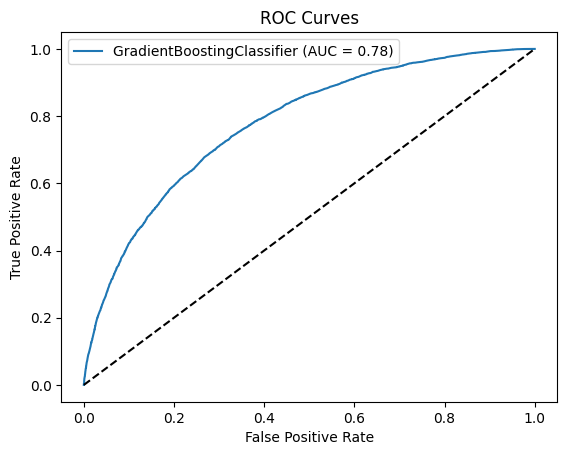

In [51]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# Using the models from the previous section
classifiers = [LogisticRegression(),
               RandomForestClassifier(),
               KNeighborsClassifier(),
               GradientBoostingClassifier()]
for classifier in classifiers:
    # Fit the classifier and make predictions
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    
    # Print classification report
    print(f"Classification report for {type(classifier).__name__}:\n")
    print(classification_report(y_test, y_pred))
    
    # Calculate and print ROC AUC score
    print(f"ROC AUC score for {type(classifier).__name__}:\n")
    print(roc_auc_score(y_test, classifier.predict_proba(X_test)[:,1]), '\n\n')
    
    # Calculate the ROC curve points
    fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f"{type(classifier).__name__} (AUC = {roc_auc_score(y_test, classifier.predict_proba(X_test)[:,1]):.2f})")

# Adding aesthetics details to the plot
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.show()


Among the four models, `Gradient Boosting Classifier` has the greatest AUC score and test accuracy. Therefore, we choose it to use to make predictions on test data.

## 4. Final Submission




The following code will write your predictions on the test dataset to a CSV file. **You will need to submit this file to get credit for this question.**

Save your predictions in a 1-dimensional array called `test_predictions` (contains 0 and 1s). 

Remember that if you've performed transformations or featurization on the training data, you must also perform the same transformations on the test data in order to make predictions. 



### Submission on Gitea

Please push all your work (ipynb, submission.csv) to the `-final` repo on Gitea. All your work should be on the master branch. 

### Submission on Canvas

Just in case you have issues with Git, submit the same items on Canvas.



In [58]:
test = pd.read_csv('test.csv')
avg_rating_by_driver_mean = test['avg_rating_by_driver'].mean()
avg_rating_of_driver_mean = test['avg_rating_of_driver'].mean()

test['avg_rating_by_driver'].fillna(avg_rating_by_driver_mean, inplace=True)
test['avg_rating_of_driver'].fillna(avg_rating_of_driver_mean, inplace=True)

test['phone'] = test['phone'].astype('category')
test = pd.get_dummies(test, columns=['city', 'phone'])
features = ['trips_in_first_30_days', 'ultimate_black_user', 
        "city_King's Landing", 'phone_iPhone', 'phone_Android',
        'avg_dist', 'city_Astapor', 'city_Winterfell']
X = test[features]

scaler = StandardScaler()
X = scaler.fit_transform(X)

test_predictions = gbc_model.predict(X)
test_predictions.sum()


738

In [59]:
submission_df = pd.DataFrame({ 
    "active": test_predictions
}, columns=['active'])
submission_df.to_csv("submission.csv", index=False)

print('Created a CSV file: submission.csv')
print('You may now upload this CSV file to Gitea for grading.')

Created a CSV file: submission.csv
You may now upload this CSV file to Gitea for grading.
